In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

In [2]:
# Load data
df = pd.read_csv('NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076607,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830318,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358780,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1079,2023-04-17,72.860001,74.940002,72.809998,74.879997,74.879997,1837700
1080,2023-04-18,74.720001,75.290001,73.584999,73.910004,73.910004,1379600
1081,2023-04-19,73.080002,73.412003,72.029999,73.150002,73.150002,1283200
1082,2023-04-20,72.440002,72.959999,71.845001,72.099998,72.099998,1554000


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Show DataFrame
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076607,1289100
2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830318,1538500
2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358780,954700
2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...
2023-04-17,72.860001,74.940002,72.809998,74.879997,74.879997,1837700
2023-04-18,74.720001,75.290001,73.584999,73.910004,73.910004,1379600
2023-04-19,73.080002,73.412003,72.029999,73.150002,73.150002,1283200


In [5]:
# Descriptive Statistical
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1.084000e+03
mean,60.464521,61.334210,59.585668,60.456292,57.144899,2.040132e+06
std,18.686912,19.108688,18.267959,18.699346,19.636769,1.173626e+06
min,24.820000,26.750999,23.848000,25.100000,22.519356,4.274000e+05
25%,48.345000,48.857500,47.932499,48.342498,43.024192,1.283275e+06
50%,54.914999,55.337500,54.365000,54.820002,51.638992,1.732200e+06
75%,74.082500,75.067503,72.779997,74.074999,72.934139,2.497475e+06
max,113.760002,117.250000,111.910004,114.500000,111.642052,1.133740e+07


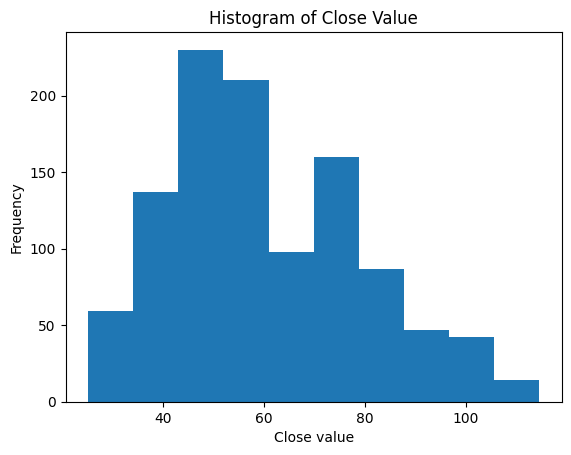

In [6]:
#  Draw a histogram
plt.hist(df['Close'])

# Set label and title
plt.xlabel('Close value')
plt.ylabel('Frequency')
plt.title('Histogram of Close Value')

# Display histogram
plt.show()

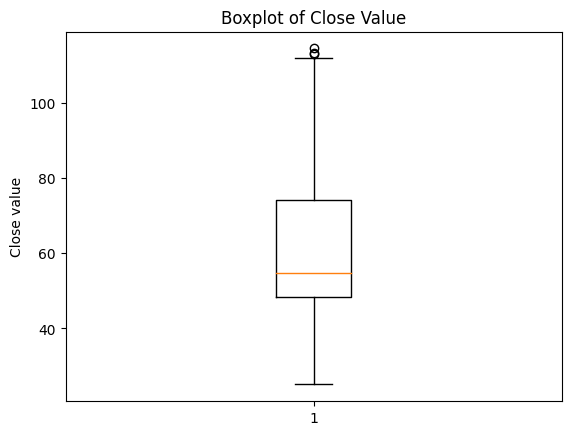

In [7]:
# Draw a boxplot
plt.boxplot(df.Close)

# Set label and title
plt.title("Boxplot of Close Value")
plt.ylabel("Close value")

# Hiển thị biểu đồ
plt.show()

In [8]:
# Select column 'Close'
data = df['Close'].values

In [9]:
# Standardized data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

In [10]:
# Split the data into train, validate, and test sets in a ratio of 7:2:1
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[0 : train_size, :]
val_data = data_scaled[train_size : train_size + val_size, :]
test_data = data_scaled[train_size + val_size : len(data_scaled), :]

In [11]:
# Create sequences
def prepare_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length - 1):
        sequences.append(data[i : (i + sequence_length), :])
        targets.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(targets)

In [12]:
sequence_length = 30
train_sequences, train_targets = prepare_sequences(train_data, sequence_length)
test_sequences, test_targets = prepare_sequences(test_data, sequence_length)
val_sequences, val_targets = prepare_sequences(val_data, sequence_length)

In [13]:
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [14]:
# Build TCAN model
def build_tcan(sequence_length, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(sequence_length, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

In [15]:
# Model building
model = build_tcan(sequence_length)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Model training
history = model.fit(train_sequences, train_targets, epochs=50, batch_size=32, validation_data=(val_sequences, val_targets), 
                    shuffle=False, callbacks=[early_stop], verbose=1)

Epoch 1/50
23/23 [==============================] - 3s 14ms/step - loss: 0.1003 - val_loss: 0.0677
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0796 - val_loss: 0.1422
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0573 - val_loss: 0.0794
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0498 - val_loss: 0.0678
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0490 - val_loss: 0.0717
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0499 - val_loss: 0.0658
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0396 - val_loss: 0.0638
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0398 - val_loss: 0.0726
Epoch 9/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0465 - val_loss: 0.0610
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0399 - val_loss: 0.0636
Epoch 11/50
23/23 

In [16]:
# Prediction on test set
y_pred = model.predict(test_sequences)

3/3 [==============================] - 0s 4ms/step


In [17]:
# Evaluate the accuracy of test
test_mae = mean_absolute_error(test_targets, y_pred)
test_mape = mean_absolute_percentage_error(test_targets, y_pred)
test_mse = mean_squared_error(test_targets, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_targets, y_pred)

print(f"MAE on Test set: ", test_mae)
print(f"MAPE on Test set: ", test_mape)
print(f"MSE on Test set: ", test_mse)
print(f"RMSE on Test set: ", test_rmse)
print(f"MSLE on Test set: ", test_msle)

MAE on Test set:  0.027242302167647964
MAPE on Test set:  0.049243640600271824
MSE on Test set:  0.001025368982173313
RMSE on Test set:  0.03202138320206223
MSLE on Test set:  0.0004191125825809469


In [18]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Predict the closing price for the next 30 days
last_sequence_days = data[-sequence_length:].reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = model.predict(last_sequence_days)
    
    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])
    
    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 16ms/step


In [19]:
len(scaler.inverse_transform(val_data))

216

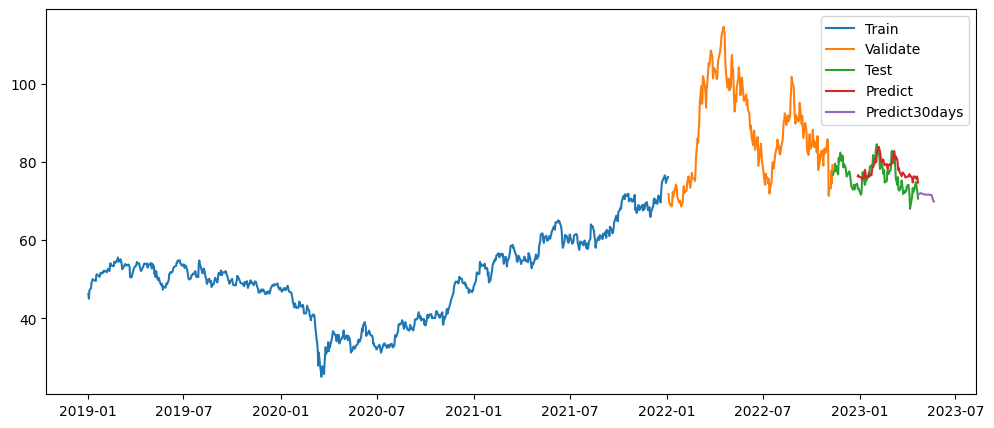

In [20]:
# Visualization
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + sequence_length + 1: ],scaler.inverse_transform(y_pred))

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])
plt.show()